**Описание исследования**

Целью данной работы является провести сравнительный анализ аниме и манг, с помощью данных, полученных через Jikan API (API платформы MyAnimeList). Для достижения данной цели будем выявлять закономерности между популярностью, рейтингом, жанрами и другими характеристиками аниме и их манга-адаптаций (и наоборот).


# Импорты библиотек

In [48]:
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import requests
from PIL import Image
from io import BytesIO

# Получение данных по API

In [2]:
data = []
pbar = tqdm(range(1, 201), desc="Loading")

for page in pbar:
    url = f"https://api.jikan.moe/v4/top/anime?page={page}"
    response = requests.get(url)
    if response.status_code == 200:
        for anime in response.json()['data']:
            data.append({
                'title': anime['title'],
                'score': anime['score'],
                'genres': ', '.join([g['name'] for g in anime['genres']]),
                'episodes': anime['episodes'],
                'members': anime['members']
            })
    else:
        print(f"Ошибка на странице {page} | Error code: {response.status_code}")
    time.sleep(0.4)

df_anime = pd.DataFrame(data)

Loading:   0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
def convert_date(x):
  if any(x[el] is None for el in ("day", "month", "year")):
    return np.nan

  return f"{x['day']}-{x['month']}-{x['year']}"


data = []

pbar = tqdm(range(1, 201), desc="Loading")

for page in pbar:
    url = f"https://api.jikan.moe/v4/top/manga?page={page}"
    response = requests.get(url)
    if response.status_code == 200:
        for manga in response.json()['data']:
            data.append({
                'title': manga['title'],
                'score': manga['score'],
                'genres': ', '.join([g['name'] for g in manga['genres']]),
                'date': convert_date(manga["published"]["prop"]["from"]),
                'members': manga['members']
            })
    else:
        print(f"Ошибка на странице {page} | Error code: {response.status_code}")
    time.sleep(0.4)

df_manga = pd.DataFrame(data)

Loading:   0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
df_anime

,title,score,genres,episodes,members
0,Sousou no Frieren,9.31,"Adventure, Drama, Fantasy",28.0,1058537
1,Fullmetal Alchemist: Brotherhood,9.10,"Action, Adventure, Drama, Fantasy",64.0,3493507
2,Steins;Gate,9.07,"Drama, Sci-Fi, Suspense",24.0,2676066
3,One Piece Fan Letter,9.05,"Action, Adventure, Fantasy",1.0,96551
4,Shingeki no Kyojin Season 3 Part 2,9.05,"Action, Drama, Suspense",10.0,2418147
...,...,...,...,...,...
4995,Kuutei Dragons,6.95,"Adventure, Fantasy",12.0,49112
4996,Strike the Blood II,6.95,"Action, Fantasy, Ecchi",8.0,203506
4997,Gunslinger Girl: Il Teatrino OVA,6.95,"Action, Drama, Sci-Fi",2.0,24659
4998,Youjo Senki Movie: Manner Eizou,6.95,Comedy,1.0,22602


In [5]:
df_manga

,title,score,genres,date,members
0,Berserk,9.47,"Action, Adventure, Award Winning, Drama, Fanta...",25-8-1989,741864
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.32,"Action, Adventure, Mystery, Supernatural",19-1-2004,288051
2,Vagabond,9.27,"Action, Adventure, Award Winning",3-9-1998,417787
3,One Piece,9.22,"Action, Adventure, Fantasy",22-7-1997,654732
4,Monster,9.16,"Award Winning, Drama, Mystery",5-12-1994,264953
...,...,...,...,...,...
4995,Kaze no Sylphid,7.35,"Drama, Sports",13-9-1989,656
4996,Sagashimono,7.35,"Drama, Romance",1-1-2009,2059
4997,Boys on the Run,7.35,"Comedy, Drama, Romance, Sports",1-1-2005,9554
4998,Love♥Zipper,7.35,Romance,1-1-2010,3593


# Обрабатываем данные и создаем новые фичи

## Проверка на NaN

Проверим данные на наличие NaN значений

In [6]:
df_anime.isna().sum()

,0
title,0
score,0
genres,0
episodes,35
members,0


Нам нужно как то обработать NaN в ```episodes```. Так как их очень мало: $\frac{35}{5000}$ мы можем просто вырезать все самплы где ```episodes``` равно NaN

In [7]:
df_anime = df_anime.dropna(axis=0).reset_index(drop=True)

In [8]:
df_manga.isna().sum()

,0
title,0
score,0
genres,0
date,19
members,0


В фиче ```data``` в DataFrame ```df_manga``` также не так много NaN удалим самплы с ними и продолжим работу

In [9]:
df_manga = df_manga.dropna(axis=0).reset_index(drop=True)

## Обработка данных

In [10]:
# Новые фичи
df_anime["num_words_in_title"] = df_anime["title"].str.split().apply(lambda x: len(x))
df_manga["num_words_in_title"] = df_manga["title"].str.split().apply(lambda x: len(x))

# Обработка данных
df_anime["genres"] = df_anime["genres"].str.split(", ")
df_manga["genres"] = df_manga["genres"].str.split(", ")



# Работа с данными

Найдем все уникальные жанры для манги и аниме

In [11]:
uniq_anime_genres = df_anime["genres"].explode().unique()
uniq_manga_genres = df_manga["genres"].explode().unique()

uniq_anime_genres = uniq_anime_genres[uniq_anime_genres != ""]
uniq_manga_genres = uniq_manga_genres[uniq_manga_genres != ""]

uniq_anime_genres = np.sort(uniq_anime_genres)
uniq_manga_genres = np.sort(uniq_manga_genres)

df_manga["date"] = pd.to_datetime(df_manga['date'], format='%d-%m-%Y')

In [12]:
uniq_anime_genres

array(['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love',
       'Comedy', 'Drama', 'Ecchi', 'Erotica', 'Fantasy', 'Girls Love',
       'Gourmet', 'Hentai', 'Horror', 'Mystery', 'Romance', 'Sci-Fi',
       'Slice of Life', 'Sports', 'Supernatural', 'Suspense'],
      dtype=object)

In [13]:
uniq_manga_genres

array(['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love',
       'Comedy', 'Drama', 'Ecchi', 'Erotica', 'Fantasy', 'Girls Love',
       'Gourmet', 'Hentai', 'Horror', 'Mystery', 'Romance', 'Sci-Fi',
       'Slice of Life', 'Sports', 'Supernatural', 'Suspense'],
      dtype=object)

In [14]:
results_anime = {}
results_manga = {}


for el in uniq_anime_genres:
    results_anime[el] = df_anime[df_anime["genres"].apply(lambda x: el in x)]["score"].mean()


for el in uniq_manga_genres:
    results_manga[el] = df_manga[df_manga["genres"].apply(lambda x: el in x)]["score"].mean()

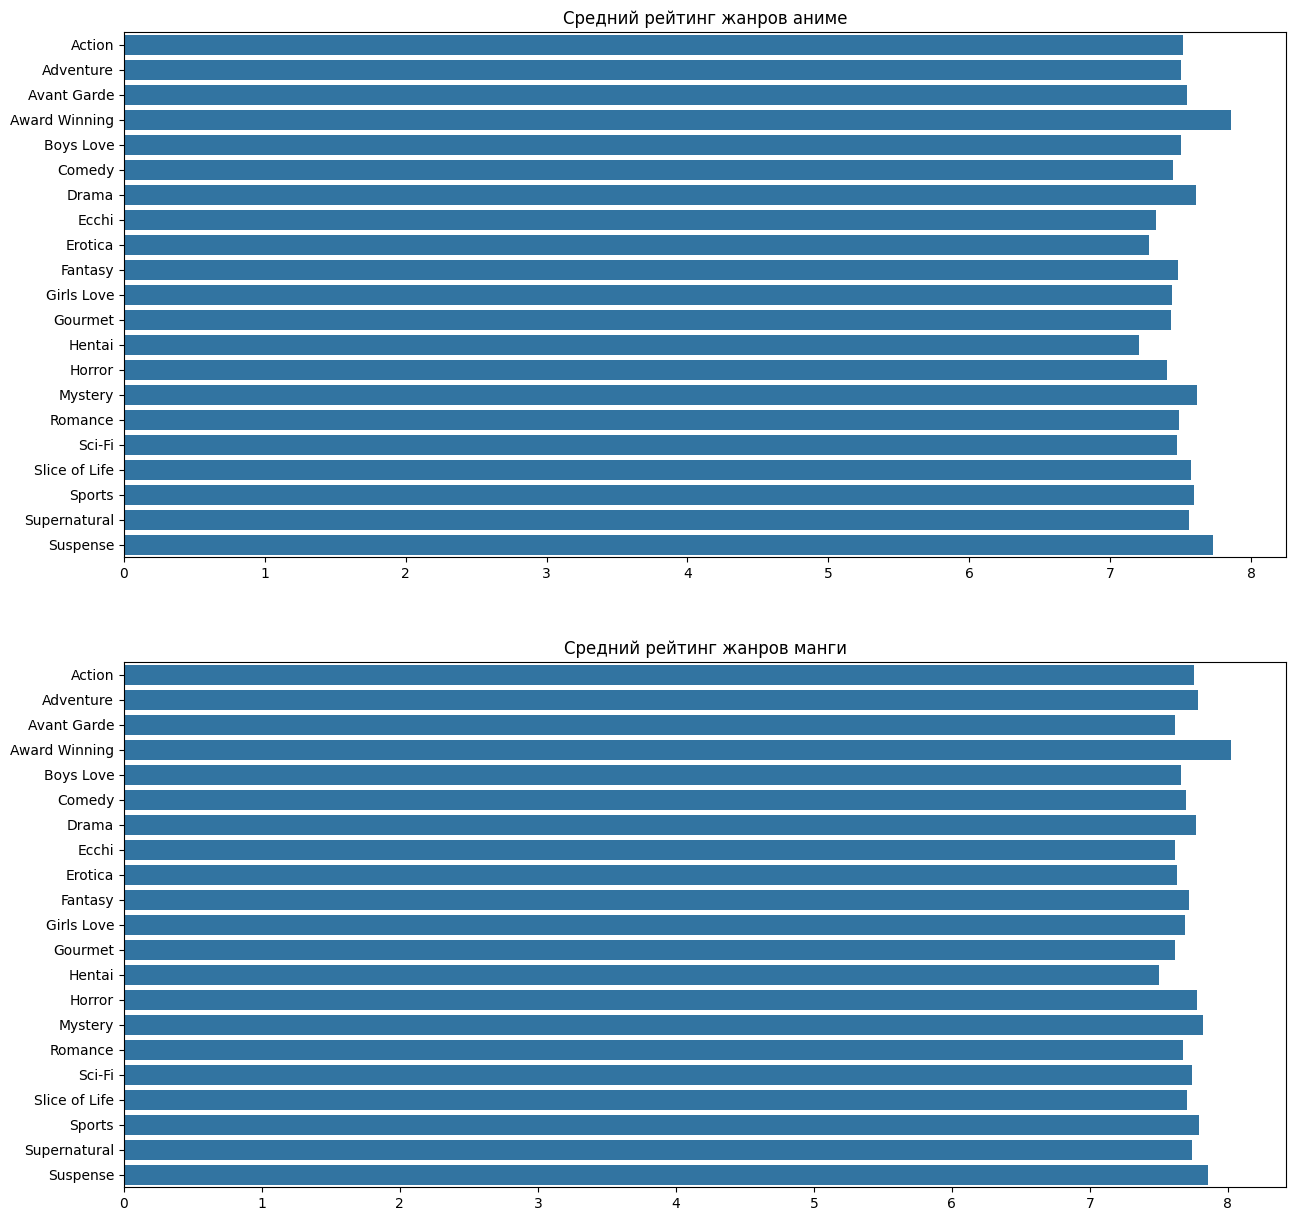

In [19]:
fig, ax = plt.subplots(2, figsize=(15, 15))

sns.barplot(x=results_anime.values(), y=results_anime.keys(), ax=ax[0], orient="h")
ax[0].set_title("Средний рейтинг жанров аниме")
sns.barplot(x=results_manga.values(), y=results_manga.keys(), ax=ax[1], orient="h")
ax[1].set_title("Средний рейтинг жанров манги");

Как мы ввдим средние очень схожи в обоих датасетах, это может быть связано с тем, что каждый самл связан сразу с несколькими категориями

Провеорим на распредление рейтингов манги с учетом года или месяца ее выхода

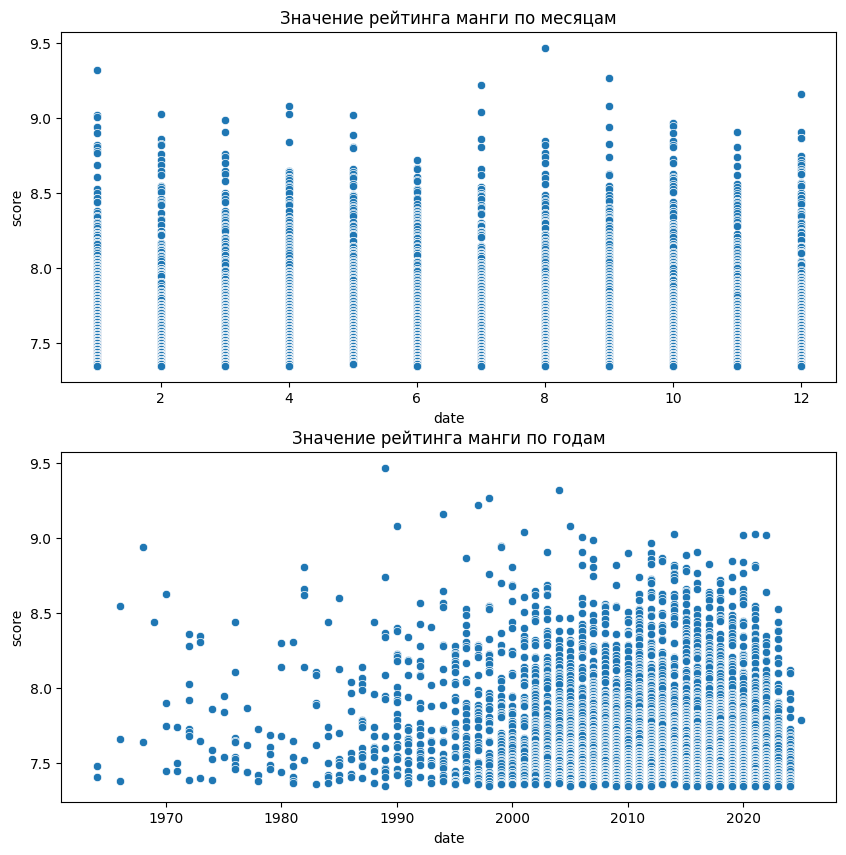

In [26]:
fig, ax = plt.subplots(2, figsize=(10, 10))

sns.scatterplot(x=df_manga["date"].dt.month, y=df_manga["score"], ax=ax[0])
ax[0].set_title("Значение рейтинга манги по месяцам");

sns.scatterplot(x=df_manga["date"].dt.year, y=df_manga["score"], ax=ax[1])
ax[1].set_title("Значение рейтинга манги по годам");

Из графика "значение рейтинга манги по месяцам" можно сказать, что нет явной сезонности у данных параметров. Из графика "значение рейтинга манги по годам" можем заметить, что до 2000 года в данных представлено меньше произведений, однако среди них больше "выделяющихся" манг. Возможно это было связано с тем, что в статистику были добавлены наиболее известные и качественные экземпляры.
 После 2000 года произошел бум жанра и популярность этого вида литературы возросла, но и разброс по рейтингу стал обширнее

Также взглянем на связь рейтинга и members(количества пользователей, добавивших аниме/мангу в список "просмотренное" или в спискок "буду смотреть"). Так как значения members очень велики, используем логарифмироввание для наглядности

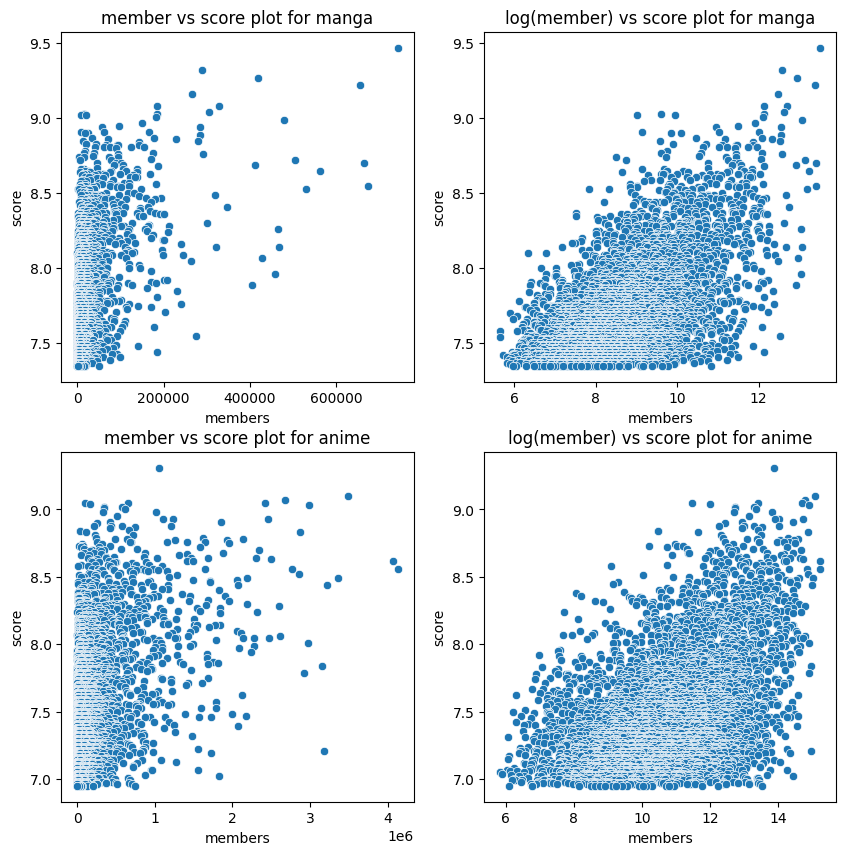

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.scatterplot(x=df_manga["members"], y=df_manga["score"], ax=ax[0][0])
ax[0][0].set_title("member vs score plot for manga");

sns.scatterplot(x=df_anime["members"], y=df_anime["score"], ax=ax[1][0])
ax[1][0].set_title("member vs score plot for anime");

sns.scatterplot(x=np.log(df_manga["members"]), y=df_manga["score"], ax=ax[0][1])
ax[0][1].set_title("log(member) vs score plot for manga");

sns.scatterplot(x=np.log(df_anime["members"]), y=df_anime["score"], ax=ax[1][1])
ax[1][1].set_title("log(member) vs score plot for anime");

Можем заметить, что чем выше рейтинг, тем больше пользователей смотрели/читали произведение или планируют это сделать

Провеорим гипотезу о том, что кол-во слов в названии влияет на популярность манги/аниме

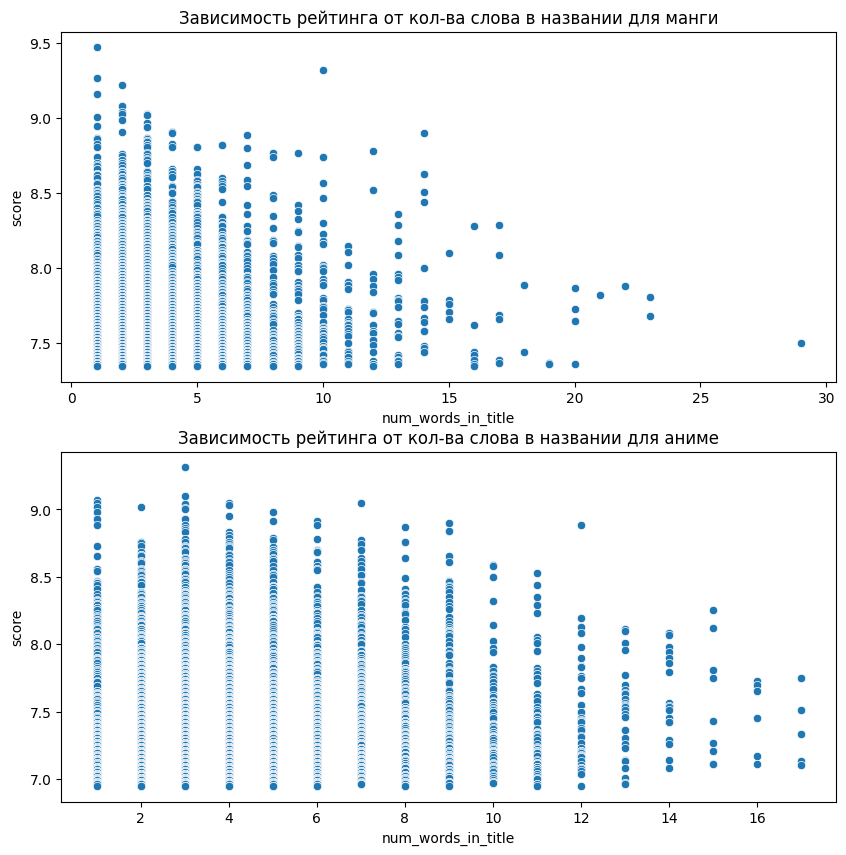

In [33]:
fig, ax = plt.subplots(2, figsize=(10, 10))

sns.scatterplot(x=df_manga["num_words_in_title"], y=df_manga["score"], ax=ax[0])
ax[0].set_title("Зависимость рейтинга от кол-ва слова в названии для манги");

sns.scatterplot(x=df_anime["num_words_in_title"], y=df_anime["score"], ax=ax[1])
ax[1].set_title("Зависимость рейтинга от кол-ва слова в названии для аниме");

Найдем, как связаны рейтинги манги и аниме, для этого отберем данные с одинаковыми title

In [43]:
anime_scores = df_anime[['title', 'score']].rename(columns={'score': 'anime_score'})
manga_scores = df_manga[['title', 'score']].rename(columns={'score': 'manga_score'})

merged_scores = pd.merge(
    anime_scores,
    manga_scores,
    on='title',
    how='inner'
)

merged_scores

,title,anime_score,manga_score
0,Sousou no Frieren,9.31,8.84
1,Steins;Gate,9.07,8.52
2,Steins;Gate,9.07,8.05
3,Ginga Eiyuu Densetsu,9.01,8.62
4,Gintama,8.93,8.63
...,...,...,...
996,Meitantei Conan: Zero no Tea Time,6.96,7.46
997,Kaibutsu Oujo,6.96,7.46
998,Satsuriku no Tenshi,6.96,7.64
999,Fukumenkei Noise,6.95,7.44


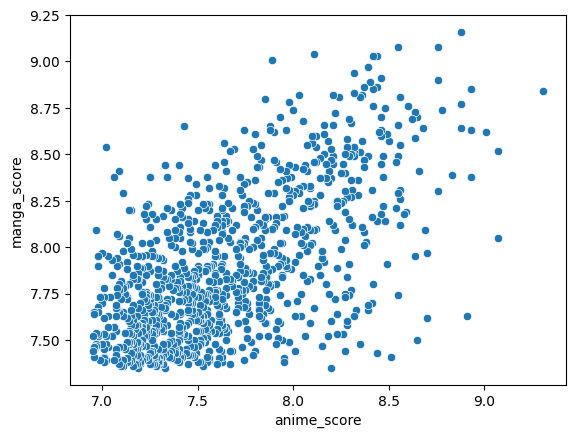

In [41]:
sns.scatterplot(x=merged_scores['anime_score'], y=merged_scores['manga_score']);

Попробуем построить линейную регрессию. Исходя из специфики данных добавлять константу нелогично, так что сделаем все без нее

In [42]:

#X = sm.add_constant(X)  # Добавляет столбец из единиц (для intercept)


model = sm.OLS(merged_scores['anime_score'], merged_scores['manga_score'])  # y - зависимая переменная, X - предикторы
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            anime_score   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          4.310e+05
Date:                Mon, 24 Mar 2025   Prob (F-statistic):                        0.00
Time:                        18:09:37   Log-Likelihood:                         -421.68
No. Observations:                1001   AIC:                                      845.4
Df Residuals:                    1000   BIC:                                      850.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
manga_score     0.9690      0.001    656.530      0.000       0.966       0.972
==============================================================================
Omnibus:                       48.113   Durbin-Watson:                   1.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.873
Skew:                           0.429   Prob(JB):                     1.83e-15
Kurtosis:                       3.945   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R2 близок к 1, а значит оценка, которую ставят пользователи аниме практически идентична той, которую они ставят манге

Покажем, что константа ухудшит результат

Как мы видим добавление константы очень сильно снизило R2

In [44]:
model = sm.OLS(merged_scores['anime_score'], sm.add_constant(merged_scores['manga_score']))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            anime_score   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     586.4
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          2.67e-102
Time:                        18:17:06   Log-Likelihood:                -380.33
No. Observations:                1001   AIC:                             764.7
Df Residuals:                     999   BIC:                             774.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1208      0.229      9.275      0.000       1.672       2.569
manga_score     0.7009      0.029     24.216      0.000       0.644       0.758
==============================================================================
Omnibus:                       61.985   Durbin-Watson:                   0.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.176
Skew:                           0.573   Prob(JB):                     1.74e-17
Kurtosis:                       3.732   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
pip install requests pillow -q

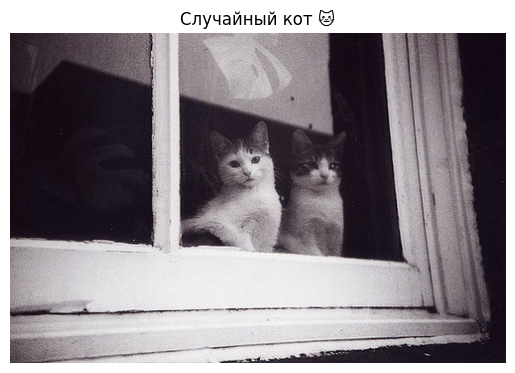

In [50]:
def get_random_cat():
    # 1. Запрос к API
    response = requests.get("https://api.thecatapi.com/v1/images/search")

    if response.status_code == 200:
        # 2. Извлекаем URL изображения
        data = response.json()
        image_url = data[0]["url"]

        # 3. Загружаем изображение
        image_response = requests.get(image_url)
        img = Image.open(BytesIO(image_response.content))

        # 4. Показываем изображение
        plt.imshow(img)
        plt.axis("off")  # Убираем оси
        plt.title("Случайный кот 🐱")
        plt.show()

    else:
        print("Ошибка при запросе:", response.status_code)

# Запускаем
get_random_cat()

вот вам в завершение рандомный кот :)
